# XGBoost

This notebook shows our process for selecting hyperparameters and features for the xgboost model

In [0]:
from pyspark.sql import types, Window, functions as F
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.ml.feature import VectorAssembler, StringIndexer
from sparkdl.xgboost import XgboostClassifier, XgboostClassifierModel
from pyspark.ml.classification import GBTClassifier
from pyspark.mllib.evaluation import MulticlassMetrics

# Good links

- [Data Clean](https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#notebook/1898361324234161/command/1898361324234162)
- [Ester Feature Eng](https://adb-731998097721284.4.azuredatabricks.net/?o=731998097721284#notebook/1898361324251838/command/1898361324251866)
- [Weather var dictionary](https://docs.google.com/spreadsheets/d/1xthRtOjC5-kV0LMIRa_grkxZ6sLBlpqDpNwygOH_jlA/edit#gid=1829391731)

# Functions and global objects for data cleaning

In [0]:
%run ../Phase_3/dataclean_functions

In [0]:
# Metrics Functions
def evaluate_metrics(df):
    '''pass in dataframe with 2 columns: prediction, label
    '''
    
    result_metrics = {'accuracy': [], 'precision': [], 'recall': [], 'f0_5_score': [], 'f1_score': [], 'f2_score': []}
    
    df = df.select('prediction', 'label')
    
    metrics = MulticlassMetrics(df.rdd)
    
    # classification metrics
    cm = metrics.confusionMatrix().toArray()
    accuracy = (cm[0][0] + cm[1][1]) / cm.sum()
    precision = (cm[0][0]) / (cm[0][0] + cm[1][0])
    recall = (cm[0][0]) / (cm[0][0] + cm[0][1])
    
    def f_score(beta, precision, recall):
        return (1+beta**2) * precision * recall / (beta**2 * precision + recall)
    
    # save all metrics
    result_metrics['accuracy'].append(accuracy)
    result_metrics['precision'].append(precision)
    result_metrics['recall'].append(recall)
    result_metrics['f0_5_score'].append(f_score(0.5, precision, recall))
    result_metrics['f1_score'].append(f_score(1, precision, recall))
    result_metrics['f2_score'].append(f_score(2, precision, recall))
    
    return result_metrics



# Function that saves all metrics from every cross validation run to a dictionary
# loop this across all grid search 
def evaluate_cross_folds(folds, model, features, y_var='DEP_DEL15_AIRLNS', verbose=True):
    '''
    Function to run through the proper cross validation with your single model and evaluate performance metrics on each fold
    
    Inputs:
    - folds: Use Yi's make_cv_folds(df) function and pass this object in
    - model: pass in a single model object to be evaluate
    - features: list of features to use as explanatory variables
    
    Output:
    - Dictionary of the main classification metrics for each k-fold CV
    '''
    
    all_metrics_train = {'accuracy': [], 'precision': [], 'recall': [], 'f0_5_score': [], 'f1_score': [], 'f2_score': []}
    all_metrics_dev = {'accuracy': [], 'precision': [], 'recall': [], 'f0_5_score': [], 'f1_score': [], 'f2_score': []}
    
    for i, fold_i in enumerate(folds):
        
        if verbose:
            print(f'Fitting model {i+1} of {len(folds)}')
        
        train = undersample(fold_i[0])
        dev = fold_i[1]
        
        # select fields we're using
        train = train.select(features + [y_var])
        dev = dev.select(features + [y_var])

        # put data into the pyspark form
        vectorAssembler = VectorAssembler(inputCols = features, outputCol = 'features', handleInvalid='skip')
        train = vectorAssembler.transform(train).select(['features', y_var])
        dev = vectorAssembler.transform(dev).select(['features', y_var])

        # cache data
        #train.cache()
        #dev.cache()
        
        # fit model
        model_fit = model.fit(train)
        
        # make preds
        train_pred = model_fit.transform(train)
        dev_pred = model_fit.transform(dev)
        dev_pred.cache()
        
        # calculate all metrics and append them to the dictionary
        results_train = evaluate_metrics(train_pred.withColumnRenamed(y_var, "label").select(['prediction', 'label']))
        results_dev = evaluate_metrics(dev_pred.withColumnRenamed(y_var, "label").select(['prediction', 'label']))
        
        for j in ['accuracy', 'precision', 'recall', 'f0_5_score', 'f1_score', 'f2_score']:
            all_metrics_train[j].append(results_train[j])
            all_metrics_dev[j].append(results_dev[j])
        
    return all_metrics_train, all_metrics_dev

# Read in Data

In [0]:
blob_container = "main-storage" # The name of your container created in https://portal.azure.com
storage_account = "team05w261" # The name of your Storage account created in https://portal.azure.com
secret_scope = "team05" # The name of the scope created in your local computer using the Databricks CLI
secret_key = "team05-key" # The name of the secret key created in your local computer using the Databricks CLI 
blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"
mount_path = "/mnt/mids-w261"

# Configure blob storage account access key globally
spark.conf.set(
  f"fs.azure.account.key.{storage_account}.blob.core.windows.net",
  dbutils.secrets.get(scope = secret_scope, key = secret_key)
)

df = spark.read.parquet(f"{blob_url}/all_time_full_join_6")

df_numrows = df.count()
print(f"number of rows: {df_numrows}")
print(f"number of columns: {len(df.columns)}")
display(df)

number of rows: 31178801
number of columns: 362

YEAR_AIRLNS QUARTER_AIRLNS MONTH_AIRLNS DAY_OF_MONTH_AIRLNS DAY_OF_WEEK_AIRLNS FL_DATE_AIRLNS CRS_DEP_TIME_AIRLNS CRS_ARR_TIME_AIRLNS CRS_ELAPSED_TIME_AIRLNS ORIGIN_AIRLNS DEST_AIRLNS OP_UNIQUE_CARRIER_AIRLNS FLIGHTS_AIRLNS DISTANCE_AIRLNS DEP_DEL15_AIRLNS LATITUDE_WTHR_origin LONGITUDE_WTHR_origin ELEVATION_WTHR_origin LATITUDE_WTHR_dest LONGITUDE_WTHR_dest ELEVATION_WTHR_dest WND_WTHR_direction_angle_origin WND_WTHR_speed_rate_origin CIG_WTHR_ceiling_height_dimension_origin VIS_WTHR_distance_dimension_origin TMP_WTHR_air_temperature_origin DEW_WTHR_dew_point_temperature_origin SLP_WTHR_sea_level_pressure_origin GA1_WTHR_base_height_dimension_origin GF1_WTHR_lowest_cloud_base_height_dimension_origin MA1_WTHR_altimeter_setting_rate_origin MA1_WTHR_station_pressure_rate_origin AA1_WTHR_period_quantity_in_hours_origin AA1_WTHR_depth_dimension_origin AA2_WTHR_period_quantity_in_hours_origin AA2_WTHR_depth_dimension_origin AJ1_WTHR_dimension_origin AJ1_WTHR_equivalent_water_depth_dimension_origin AL1_WTHR_period_quantity_origin AL1_WTHR_depth_dimension_origin AN1_WTHR_period_quantity_origin AN1_WTHR_depth_dimension_origin AO1_WTHR_period_quantity_in_minutes_origin AO1_WTHR_depth_dimension_origin WND_WTHR_direction_angle_dest WND_WTHR_speed_rate_dest CIG_WTHR_ceiling_height_dimension_dest VIS_WTHR_distance_dimension_dest TMP_WTHR_air_temperature_dest DEW_WTHR_dew_point_temperature_dest SLP_WTHR_sea_level_pressure_dest GA1_WTHR_base_height_dimension_dest GF1_WTHR_lowest_cloud_base_height_dimension_dest MA1_WTHR_altimeter_setting_rate_dest MA1_WTHR_station_pressure_rate_dest AA1_WTHR_period_quantity_in_hours_dest AA1_WTHR_depth_dimension_dest AA2_WTHR_period_quantity_in_hours_dest AA2_WTHR_depth_dimension_dest AJ1_WTHR_dimension_dest AJ1_WTHR_equivalent_water_depth_dimension_dest AL1_WTHR_period_quantity_dest AL1_WTHR_depth_dimension_dest AN1_WTHR_period_quantity_dest AN1_WTHR_depth_dimension_dest AO1_WTHR_period_quantity_in_minutes_dest AO1_WTHR_depth_dimension_dest WND_WTHR_type_code_origin-V WND_WTHR_type_code_origin-C WND_WTHR_type_code_origin-N WND_WTHR_type_code_origin-R WND_WTHR_type_code_origin-H CIG_WTHR_ceiling_determination_code_origin-M CIG_WTHR_ceiling_determination_code_origin-C CIG_WTHR_ceiling_determination_code_origin-W CIG_WTHR_CAVOK_code_origin-Y CIG_WTHR_CAVOK_code_origin-N GA1_WTHR_coverage_code_origin-00 GA1_WTHR_coverage_code_origin-01 GA1_WTHR_coverage_code_origin-02 GA1_WTHR_coverage_code_origin-03 GA1_WTHR_coverage_code_origin-04 GA1_WTHR_coverage_code_origin-05 GA1_WTHR_coverage_code_origin-06 GA1_WTHR_coverage_code_origin-07 GA1_WTHR_coverage_code_origin-08 GA1_WTHR_coverage_code_origin-09 GA1_WTHR_coverage_code_origin-10 GA1_WTHR_cloud_type_code_origin-00 GA1_WTHR_cloud_type_code_origin-01 GA1_WTHR_cloud_type_code_origin-02 GA1_WTHR_cloud_type_code_origin-03 GA1_WTHR_cloud_type_code_origin-04 GA1_WTHR_cloud_type_code_origin-05 GA1_WTHR_cloud_type_code_origin-06 GA1_WTHR_cloud_type_code_origin-07 GA1_WTHR_cloud_type_code_origin-08 GA1_WTHR_cloud_type_code_origin-09 GA1_WTHR_cloud_type_code_origin-10 GA1_WTHR_cloud_type_code_origin-12 GA1_WTHR_cloud_type_code_origin-15 GF1_WTHR_total_coverage_code_origin-00 GF1_WTHR_total_coverage_code_origin-01 GF1_WTHR_total_coverage_code_origin-02 GF1_WTHR_total_coverage_code_origin-03 GF1_WTHR_total_coverage_code_origin-04 GF1_WTHR_total_coverage_code_origin-05 GF1_WTHR_total_coverage_code_origin-06 GF1_WTHR_total_coverage_code_origin-07 GF1_WTHR_total_coverage_code_origin-08 GF1_WTHR_total_coverage_code_origin-09 GF1_WTHR_total_lowest_cloud_cover_code_origin-00 GF1_WTHR_total_lowest_cloud_cover_code_origin-01 GF1_WTHR_total_lowest_cloud_cover_code_origin-02 GF1_WTHR_total_lowest_cloud_cover_code_origin-03 GF1_WTHR_total_lowest_cloud_cover_code_origin-04 GF1_WTHR_total_lowest_cloud_cover_code_origin-05 GF1_WTHR_total_lowest_cloud_cover_code_origin-06 GF1_WTHR_total_lowest_cloud_cover_code_origin-07 GF1_WTHR_total_lowest_cloud_cover_code_origin-08 GF1_WTHR_total_lowest_c

# Data Clean

In [0]:
def clean_data_for_tree_model(df):

    # cast to int
    str_cols = ['Prev_Flight_Delay_15', 'Poor_Schedule', 'Enough_Time_Btwn_Estimate_Arrival_and_Planned_Dep']
    for column in str_cols:
        df = df.withColumn(column, F.col(column).cast(types.IntegerType())) 

    # impute some missing values
    df = df.na.fill({
        'LATITUDE_WTHR_origin': 0
        ,'LONGITUDE_WTHR_origin': 0
        ,'ELEVATION_WTHR_origin': 0
        ,'LATITUDE_WTHR_dest': 0
        ,'LONGITUDE_WTHR_dest': 0
        ,'ELEVATION_WTHR_dest': 0
        ,'Prev_Flight_Delay_15': 0
        #,'DEP_DEL15_AIRLNS': 0
    })

    # vars to index
    # Specify which columns to index (ie cast to int)
    vars_to_index = [
        'ORIGIN_AIRLNS', 
        'DEST_AIRLNS', 
        'OP_UNIQUE_CARRIER_AIRLNS' # a more granular form of origin/dest airlines
    ]

    # rename cols to drop them later
    for var in vars_to_index:
        df = df.withColumnRenamed(var, var+'_old')

    # finally, index them
    indexer = StringIndexer(inputCols=[i+'_old' for i in vars_to_index], outputCols=vars_to_index)
    df = indexer.fit(df).transform(df)
    df = df.drop(*[i+'_old' for i in vars_to_index])

    # drop missing values from Y var
    df = df.filter(~F.col('DEP_DEL15_AIRLNS').isNull())
    
    return df

In [0]:
df = clean_data_for_tree_model(df)

# Modeling

In [0]:
# select explanatory vars
X_vars = [
    # time vars
    'YEAR_AIRLNS', 'QUARTER_AIRLNS', 'MONTH_AIRLNS', 'DAY_OF_WEEK_AIRLNS', 
  #'CRS_DEP_TIME_AIRLNS', 'CRS_ARR_TIME_AIRLNS', 
    
    # airport location stuff
    'CRS_ELAPSED_TIME_AIRLNS', 'DISTANCE_AIRLNS', 'ELEVATION_WTHR_origin', 'ELEVATION_WTHR_dest', 
    'LATITUDE_WTHR_origin', 'LONGITUDE_WTHR_origin', 'LATITUDE_WTHR_dest', 'LONGITUDE_WTHR_dest',
    
    # airport cat vars to encode/index
    'ORIGIN_AIRLNS', 'DEST_AIRLNS', 'OP_UNIQUE_CARRIER_AIRLNS', 
    
    # weather vars origin
    'WND_WTHR_direction_angle_origin', 'WND_WTHR_speed_rate_origin', 'TMP_WTHR_air_temperature_origin', 'DEW_WTHR_dew_point_temperature_origin',
    'VIS_WTHR_distance_dimension_origin', 'GA1_WTHR_base_height_dimension_origin', 'GF1_WTHR_lowest_cloud_base_height_dimension_origin', 
    'AA1_WTHR_period_quantity_in_hours_origin', 'AA1_WTHR_depth_dimension_origin', 'AA2_WTHR_depth_dimension_origin', 
    'AJ1_WTHR_equivalent_water_depth_dimension_origin', 'AN1_WTHR_depth_dimension_origin', 
    'AL1_WTHR_period_quantity_origin', 'AL1_WTHR_depth_dimension_origin',
    
    # same weather vars, but for dest
    'WND_WTHR_direction_angle_dest', 'WND_WTHR_speed_rate_dest', 'TMP_WTHR_air_temperature_dest', 'DEW_WTHR_dew_point_temperature_dest',
    'VIS_WTHR_distance_dimension_dest', 'GA1_WTHR_base_height_dimension_dest', 'GF1_WTHR_lowest_cloud_base_height_dimension_dest', 
    'AA1_WTHR_period_quantity_in_hours_dest', 'AA1_WTHR_depth_dimension_dest', 'AA2_WTHR_depth_dimension_dest', 
    'AJ1_WTHR_equivalent_water_depth_dimension_dest', 'AN1_WTHR_depth_dimension_dest', 
    'AL1_WTHR_period_quantity_dest', 'AL1_WTHR_depth_dimension_dest',
    
    # esther feature eng
    'LOCAL_DEP_HOUR', 'HOLIDAY', 'Prev_Flight_Delay_15', 'Enough_Time_Btwn_Estimate_Arrival_and_Planned_Dep', 'Poor_Schedule'
]

y_var = 'DEP_DEL15_AIRLNS'


df = df.select(X_vars + [y_var])
display(df)

YEAR_AIRLNS QUARTER_AIRLNS MONTH_AIRLNS DAY_OF_WEEK_AIRLNS CRS_ELAPSED_TIME_AIRLNS DISTANCE_AIRLNS ELEVATION_WTHR_origin ELEVATION_WTHR_dest LATITUDE_WTHR_origin LONGITUDE_WTHR_origin LATITUDE_WTHR_dest LONGITUDE_WTHR_dest ORIGIN_AIRLNS DEST_AIRLNS OP_UNIQUE_CARRIER_AIRLNS WND_WTHR_direction_angle_origin WND_WTHR_speed_rate_origin TMP_WTHR_air_temperature_origin DEW_WTHR_dew_point_temperature_origin VIS_WTHR_distance_dimension_origin GA1_WTHR_base_height_dimension_origin GF1_WTHR_lowest_cloud_base_height_dimension_origin AA1_WTHR_period_quantity_in_hours_origin AA1_WTHR_depth_dimension_origin AA2_WTHR_depth_dimension_origin AJ1_WTHR_equivalent_water_depth_dimension_origin AN1_WTHR_depth_dimension_origin AL1_WTHR_period_quantity_origin AL1_WTHR_depth_dimension_origin WND_WTHR_direction_angle_dest WND_WTHR_speed_rate_dest TMP_WTHR_air_temperature_dest DEW_WTHR_dew_point_temperature_dest VIS_WTHR_distance_dimension_dest GA1_WTHR_base_height_dimension_dest GF1_WTHR_lowest_cloud_base_height_dimension_dest AA1_WTHR_period_quantity_in_hours_dest AA1_WTHR_depth_dimension_dest AA2_WTHR_depth_dimension_dest AJ1_WTHR_equivalent_water_depth_dimension_dest AN1_WTHR_depth_dimension_dest AL1_WTHR_period_quantity_dest AL1_WTHR_depth_dimension_dest LOCAL_DEP_HOUR HOLIDAY Prev_Flight_Delay_15 Enough_Time_Btwn_Estimate_Arrival_and_Planned_Dep Poor_Schedule DEP_DEL15_AIRLNS 2015 1 1 4 168.0 992.0 3.4 3.0 26.07875 -80.16217 39.87327 -75.22678 22.0 21.0 18.0 90.0 3.6 24.4 20.6 16093.0 762.0 762.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 250.0 11.3 4.4 -11.1 16093.0 7620.0 7620.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 14 1 0 1 0 0.0 2015 1 1 4 167.0 920.0 3.0 5.8 39.87327 -75.22678 27.96194 -82.5403 21.0 26.0 18.0 220.0 8.2 5.6 -10.0 16093.0 7620.0 7620.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 2.6 22.2 16.7 16093.0 640.0 640.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 17 1 0 1 0 1.0 2015 1 1 5 100.0 507.0 5.8 221.9 27.96194 -82.5403 35.2236 -80.9552 26.0 7.0 18.0 50.0 2.1 17.2 16.7 805.0 61.0 61.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 7.2 0.0 16093.0 3353.0 3353.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 6 2 1 1 0 0.0 2015 1 1 6 107.0 541.0 221.9 3.4 35.2236 -80.9552 40.6386 -73.7622 7.0 18.0 18.0 60.0 1.5 8.9 7.2 12000.0 450.0 450.0 3.0 3.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 0.0 -6.7 16000.0 0.0 6000.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 7 2 0 1 0 0.0 2015 1 1 6 120.0 541.0 3.4 221.9 40.6386 -73.7622 35.2236 -80.9552 18.0 7.0 18.0 50.0 3.6 -0.6 -6.1 16000.0 0.0 6000.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 60.0 2.1 8.9 7.2 12000.0 250.0 250.0 6.0 3.0 6.1 0.0 0.0 0.0 0.0 10 2 0 1 0 0.0 2015 1 1 6 212.0 1475.0 221.9 2.7 35.2236 -80.9552 18.4325 -66.01083 7.0 50.0 18.0 40.0 2.1 9.4 7.2 4000.0 150.0 150.0 3.0 0.0 0.0 0.0 0.0 0.0 0.0 60.0 9.8 28.3 21.1 16093.0 884.0 884.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 13 2 0 1 0 1.0 2015 1 1 6 222.0 1475.0 2.7 221.9 18.4325 -66.01083 35.2236 -80.9552 50.0 7.0 18.0 60.0 7.7 27.2 23.3 16093.0 732.0 732.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 10.0 2.1 11.0 9.0 1609.0 152.0 152.0 1.0 0.2 0.0 0.0 0.0 0.0 0.0 18 2 1 0 0 1.0 2015 1 1 6 162.0 930.0 221.9 265.8 35.2236 -80.9552 44.8831 -93.2289 7.0 10.0 18.0 360.0 1.5 10.0 8.9 1600.0 75.0 75.0 6.0 3.0 0.0 0.0 0.0 0.0 0.0 350.0 6.7 -2.2 -6.7 11000.0 800.0 800.0 0.0 0.0 0.0 80.0 0.0 0.0 0.0 22 2 1 0 0 1.0 2015 1 1 7 157.0 930.0 265.8 221.9 44.8831 -93.2289 35.2236 -80.9552 10.0 7.0 18.0 330.0 7.2 -15.6 -20.0 16093.0 0.0 6000.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 320.0 3.1 8.9 7.8 805.0 61.0 61.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 5 2 1 1 0 0.0 2015 1 1 7 87.0 361.0 221.9 47.5 35.2236 -80.9552 39.1733 -76.684 7.0 19.0 18.0 90.0 1.5 8.9 8.3 402.0 61.0 61.0 1.0 0.0 0.3 0.0 0.0 0.0 0.0 230.0 1.5 6.7 6.1 9656.0 183.0 183.0 1.0 0.5 3.6 0.0 0.0 0.0 0.0 9 2 0 1 0 0.0 2015 1 1 7 87.0 361.0 47.5 221.9 39.1733 -76.684 35.2236 -80.9552 19.0 7.0 18.0 190.0 3.1 9.0 8.0 16093.0 183.0 183.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1.0 0.0 10.0 9.0 402.0 274.0 274.0 1.0 4.3 0.0 0.0 0.0 0.0 0.0 12 2 0 1 0 0.0 2015 1 1 7 106.0 541.0 221.9 3.4 35.2236 -80.9552 40.6386 -73.7622 7.0 18.0 18.0 170.0 3.6 13.0 12.0 11265.0 61.0 

In [0]:
# optional. check for nulls
# for var in df.columns:
#     num_nulls = df.select(f'{var}').filter(f'{var} is null').count()
#     num_nans = df.filter(F.isnan(f'{var}')).count()
#     print(f'nulls: {num_nulls}, nans: {num_nans} in {var}')

# GBT

Use a GBT model just for extracting feature importances

In [0]:
spark.catalog.clearCache()

# train/test split
df_train = df.filter(F.col('YEAR_AIRLNS')<=2018).sample(.1, seed=1)
df_test = df.filter(F.col('YEAR_AIRLNS')==2019)

# undersample train
df_train = undersample(df_train)

# select fields we're using
df_train = df_train.select(X_vars + [y_var])
df_test = df_test.select(X_vars + [y_var])

# put data into the pyspark form
vectorAssembler = VectorAssembler(inputCols = X_vars, outputCol = 'features', handleInvalid='skip')
df_train = vectorAssembler.transform(df_train).select(['features', y_var])
df_test = vectorAssembler.transform(df_test).select(['features', y_var])

# cache data
df_train.cache()
df_test.cache()
print(f'train row count {df_train.count()}')
print(f'test row count {df_test.count()}')

# fit model
gbt_fit = GBTClassifier(featuresCol='features', labelCol=y_var, seed=1
                       ,featureSubsetStrategy='sqrt'
                       ,subsamplingRate=.8
                       ,maxBins=370
                       ,stepSize=.1
                       ,maxIter=50 # increase later to 100
                       ,maxDepth=12 # maybe make 15 later
                      )
gbt_fit = gbt_fit.fit(df_train)

# make preds
df_train = gbt_fit.transform(df_train)
df_test = gbt_fit.transform(df_test)
df_train.cache()
df_test.cache()
print(df_train.count())
print(df_test.count())

tr_metrics = evaluate_metrics(df_train.withColumnRenamed("dep_del15_airlns", "label").select(['prediction', 'label']))
te_metrics = evaluate_metrics(df_test.withColumnRenamed("dep_del15_airlns", "label").select(['prediction', 'label']))
print(tr_metrics)
print(te_metrics)

train row count 862278
test row count 7268232
862278
7268232
{'accuracy': [0.8077638534208225], 'precision': [0.7719681374007885], 'recall': [0.8731127082288707], 'f0_5_score': [0.7902778734970441], 'f1_score': [0.8194310849864868], 'f2_score': [0.8508175961772069]}
{'accuracy': [0.7576651378216875], 'precision': [0.90834987178562], 'recall': [0.7810147574556116], 'f0_5_score': [0.8796660657536113], 'f1_score': [0.8398834005612161], 'f2_score': [0.8035433644062916]}

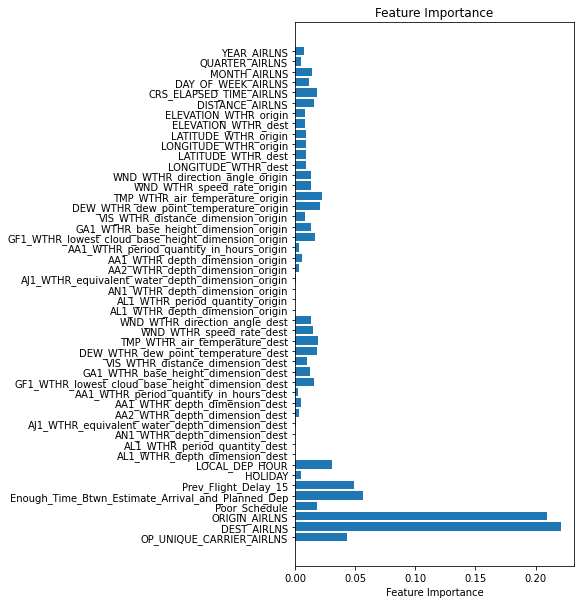

In [0]:
# varimp plot

list_extract = []
for i in df_train.schema['features'].metadata["ml_attr"]["attrs"]:
    list_extract = list_extract + df_train.schema['features'].metadata["ml_attr"]["attrs"][i]
varlist = pd.DataFrame(list_extract)
varlist['score'] = varlist['idx'].apply(lambda x: gbt_fit.featureImportances[x])
varlist.sort_values('score', ascending = False)

fig, ax = plt.subplots(figsize=(5, 10))
x = np.arange(len(varlist.name))
ax.barh(x, varlist.score)
ax.set_yticks(np.arange(len(varlist.name)))
ax.set_yticklabels(varlist.name)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Feature Importance')
ax.set_title('Feature Importance')
print("")

# XGBoost

Test out on 10% of the dataset first. Just 1 iteration.

In [0]:
# train/test split
df_train = df.filter(F.col('YEAR_AIRLNS')<=2018).sample(.1, seed=1)
df_test = df.filter(F.col('YEAR_AIRLNS')==2019)

# undersample train
df_train = undersample(df_train)

# select fields we're using
df_train = df_train.select(X_vars + [y_var])
df_test = df_test.select(X_vars + [y_var])

# put data into the pyspark form
vectorAssembler = VectorAssembler(inputCols = X_vars, outputCol = 'features', handleInvalid='skip')
df_train = vectorAssembler.transform(df_train).select(['features', y_var])
df_test = vectorAssembler.transform(df_test).select(['features', y_var])

# cache data
df_train.cache()
df_test.cache()
print(f'train row count {df_train.count()}')
print(f'test row count {df_test.count()}')

# fit xgb
xgb = XgboostClassifier(
    labelCol=y_var
    ,missing=0.0 # not so sure I wanna use this
    
    # tree params
    ,max_depth=12
    ,n_estimators=50
    ,learning_rate=.1
    ,colsample_bytree=.8 # use 80% of the columns for each tree
    
    # regularization stuff
    ,gamma=.1 # min loss needed to keep making splits. Making this low b/c response is classification
    ,reg_alpha=0 # L1
    ,reg_lambda=0 # L2 loss regularization. Apparently it regularizes the loss function in the leaf nodes somehow (?). 
    ,min_child_weight=0 # not so sure how to use this hyperparam, so gonna keep it at 0. It regularizes how much to keep splitting.
)

xgb = xgb.fit(df_train)

# make preds
df_train = xgb.transform(df_train)
df_test = xgb.transform(df_test)
df_train.cache()
df_test.cache()
print(df_train.count())
print(df_test.count())

tr_metrics = evaluate_metrics(df_train.withColumnRenamed("dep_del15_airlns", "label").select(['prediction', 'label']))
te_metrics = evaluate_metrics(df_test.withColumnRenamed("dep_del15_airlns", "label").select(['prediction', 'label']))
print(tr_metrics)
print(te_metrics)

train row count 862278
test row count 7268232
862278
7268232
{'accuracy': [0.7840255694799125], 'precision': [0.740733740485669], 'recall': [0.8733819897115902], 'f0_5_score': [0.7639389745489042], 'f1_score': [0.8016073395590044], 'f2_score': [0.8431830793241841]}
{'accuracy': [0.7974712419746646], 'precision': [0.9092614800098973], 'recall': [0.8343944898646153], 'f0_5_score': [0.8932322254940009], 'f1_score': [0.8702207108217617], 'f2_score': [0.8483650672006354]}

Cross validation eval

In [0]:
# make folds
# for now, just sample a portion of the dataset to speed things up
spark.catalog.clearCache()
df_sample = df.sample(.1, seed=1)
df_sample.cache()
folds = make_cv_folds(df_sample)


xgb = XgboostClassifier(
    labelCol=y_var
    ,missing=0.0 # not so sure I wanna use this
    
    # tree params
    ,max_depth=10
    ,n_estimators=50 # perhaps try up to 100 later and run overnight
    ,learning_rate=.1
    ,colsample_bytree=.8 # use 80% of the columns for each tree
    
    # regularization stuff
    ,gamma=.01 # min loss needed to keep making splits. Making this low b/c response is classification
    ,reg_alpha=0 # going to go w/ 0 L1 regularization
    ,reg_lambda=.1 # L2 loss regularization. Apparently it regularizes the loss function in the leaf nodes somehow (?). 
    ,min_child_weight=0 # not so sure how to use this hyperparam, so gonna keep it at 0. It regularizes how much to keep splitting.
)

xgb_results = evaluate_cross_folds(folds, model=xgb, features=X_vars, y_var='DEP_DEL15_AIRLNS')
print(xgb_results)
print("")
print('average accuracy: {}'.format(np.mean(xgb_results['accuracy'])))
print('average precision: {}'.format(np.mean(xgb_results['precision'])))
print('average recall: {}'.format(np.mean(xgb_results['recall'])))
print('average f_0.5 score: {}'.format(np.mean(xgb_results['f0_5_score'])))
print('average f_1 score: {}'.format(np.mean(xgb_results['f1_score'])))
print('average f_2 score: {}'.format(np.mean(xgb_results['f2_score'])))

Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
Fitting model 5 of 5
{'accuracy': [[0.823363569502329], [0.7839224870942949], [0.7778325669012134], [0.7628823314801], [0.8212298674047446]], 'precision': [[0.9214864487286951], [0.9128405433954848], [0.9112315600382602], [0.9084254556319091], [0.9129312986892654]], 'recall': [[0.8662475428726361], [0.8164600071775416], [0.8033483703774801], [0.7836499657480822], [0.8675101084328374]], 'f0_5_score': [[0.9098821686661207], [0.8917860359891907], [0.8873974984626662], [0.8803897095466037], [0.9034704970367956]], 'f1_score': [[0.8930135867547703], [0.8619644472624082], [0.8538959027891639], [0.8414371702297331], [0.8896413291104073]], 'f2_score': [[0.8767590837756948], [0.8340728060107532], [0.8228318313130846], [0.8057854697921984], [0.8762291369943043]]}

average accuracy: 0.7938461644765364
average precision: 0.9133830612967231
average recall: 0.8274431989217155
average f_0.5 score: 0.8945851819402753
average f_1 score: 0.8679904872292965
average f_2 score: 0.8431356655772071

Cross validation 2

In [0]:
# make folds
# for now, just sample a portion of the dataset to speed things up
spark.catalog.clearCache()
df_sample = df.sample(.1, seed=2)

folds = make_cv_folds(df_sample)


xgb = XgboostClassifier(
    labelCol=y_var
    ,missing=0.0 # I believe this saves memory to make the matrix less sparse
    
    # tree params
    ,max_depth=15
    ,n_estimators=70 # perhaps try up to 100 later and run overnight
    ,learning_rate=.1
    ,colsample_bytree=.8 # use 80% of the columns for each tree
    
    # regularization stuff
    ,gamma=.01 # min loss needed to keep making splits. Making this low b/c response is classification
    ,reg_alpha=0 # going to go w/ 0 L1 regularization
    ,reg_lambda=.05 # L2 loss regularization. Apparently it regularizes the loss function in the leaf nodes somehow (?). 
    #,min_child_weight=0 # not so sure how to use this hyperparam, so gonna keep it at 0. It regularizes how much to keep splitting.
)

xgb_results = evaluate_cross_folds(folds, model=xgb, features=X_vars, y_var='DEP_DEL15_AIRLNS')

print("Train Results:")
print('average accuracy: {}'.format(np.mean(xgb_results[0]['accuracy'])))
print('average precision: {}'.format(np.mean(xgb_results[0]['precision'])))
print('average recall: {}'.format(np.mean(xgb_results[0]['recall'])))
print('average f_0.5 score: {}'.format(np.mean(xgb_results[0]['f0_5_score'])))
print('average f_1 score: {}'.format(np.mean(xgb_results[0]['f1_score'])))
print('average f_2 score: {}'.format(np.mean(xgb_results[0]['f2_score'])))

print("\nDev Results:")
print('average accuracy: {}'.format(np.mean(xgb_results[1]['accuracy'])))
print('average precision: {}'.format(np.mean(xgb_results[1]['precision'])))
print('average recall: {}'.format(np.mean(xgb_results[1]['recall'])))
print('average f_0.5 score: {}'.format(np.mean(xgb_results[1]['f0_5_score'])))
print('average f_1 score: {}'.format(np.mean(xgb_results[1]['f1_score'])))
print('average f_2 score: {}'.format(np.mean(xgb_results[1]['f2_score'])))

Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
Fitting model 5 of 5
Train Results:
average accuracy: 0.8700775951125952
average precision: 0.8314654352391688
average recall: 0.9285359220036113
average f_0.5 score: 0.8492138891946379
average f_1 score: 0.8773111599179281
average f_2 score: 0.9073410152601463

Dev Results:
average accuracy: 0.7752563317018784
average precision: 0.914109014439903
average recall: 0.8017488662096858
average f_0.5 score: 0.8889838013052256
average f_1 score: 0.8539681050808197
average f_2 score: 0.8217938165241432

In [0]:
# make folds
# for now, just sample a portion of the dataset to speed things up
spark.catalog.clearCache()
df_sample = df.sample(.1, seed=3)

folds = make_cv_folds(df_sample)


xgb = XgboostClassifier(
    labelCol=y_var
    ,missing=0.0 # I believe this saves memory to make the matrix less sparse
    
    # tree params
    ,max_depth=10
    ,n_estimators=70 # perhaps try up to 100 later and run overnight
    ,learning_rate=.1
    ,colsample_bytree=.8 # use 80% of the columns for each tree
    
    # regularization stuff
    ,gamma=.07 # min loss needed to keep making splits. Making this low b/c response is classification
    ,reg_alpha=.07 # L1
    ,reg_lambda=.07 # L2 loss regularization. Apparently it regularizes the loss function in the leaf nodes somehow (?). 
    #,min_child_weight=0 # not so sure how to use this hyperparam, so gonna keep it at 0. It regularizes how much to keep splitting.
)

xgb_results = evaluate_cross_folds(folds, model=xgb, features=X_vars, y_var='DEP_DEL15_AIRLNS')

print("\nTrain Results:")
print('average accuracy: {}'.format(np.mean(xgb_results[0]['accuracy'])))
print('average precision: {}'.format(np.mean(xgb_results[0]['precision'])))
print('average recall: {}'.format(np.mean(xgb_results[0]['recall'])))
print('average f_0.5 score: {}'.format(np.mean(xgb_results[0]['f0_5_score'])))
print('average f_1 score: {}'.format(np.mean(xgb_results[0]['f1_score'])))
print('average f_2 score: {}'.format(np.mean(xgb_results[0]['f2_score'])))

print("\nDev Results:")
print('average accuracy: {}'.format(np.mean(xgb_results[1]['accuracy'])))
print('average precision: {}'.format(np.mean(xgb_results[1]['precision'])))
print('average recall: {}'.format(np.mean(xgb_results[1]['recall'])))
print('average f_0.5 score: {}'.format(np.mean(xgb_results[1]['f0_5_score'])))
print('average f_1 score: {}'.format(np.mean(xgb_results[1]['f1_score'])))
print('average f_2 score: {}'.format(np.mean(xgb_results[1]['f2_score'])))

Fitting model 1 of 5
Fitting model 2 of 5
Fitting model 3 of 5
Fitting model 4 of 5
Fitting model 5 of 5

Train Results:
average accuracy: 0.7637096851012133
average precision: 0.7239951833997427
average recall: 0.8519603172514877
average f_0.5 score: 0.7464163938369357
average f_1 score: 0.7827801263278559
average f_2 score: 0.8228702839823117

Dev Results:
average accuracy: 0.7902097102286436
average precision: 0.9137437424159985
average recall: 0.822089170155732
average f_0.5 score: 0.8935996761371638
average f_1 score: 0.8651925518123177
average f_2 score: 0.8387412427028572

Hyperparameter tune round 1

In [0]:
# make folds
# for now, just sample a portion of the dataset to speed things up
spark.catalog.clearCache()
df_sample = df.sample(.25, seed=123)

folds = make_cv_folds(df_sample)

for reg_gamma_ in [0, .1]:
    for reg_alpha_ in [0, .1]:
        for reg_lambda_ in [0, .1]:
            
            xgb = XgboostClassifier(
                labelCol=y_var
                ,missing=0.0 # I believe this saves memory to make the matrix less sparse

                # tree params
                ,max_depth=10
                ,n_estimators=70 # perhaps try up to 100 later and run overnight
                ,learning_rate=.1
                ,colsample_bytree=.8 # use 80% of the columns for each tree

                # regularization stuff
                ,gamma = reg_gamma_ # min loss needed to keep making splits. 
                ,reg_alpha = reg_alpha_ # L1
                ,reg_lambda = reg_lambda_ # L2 loss regularization. Apparently it regularizes the loss function in the leaf nodes somehow
                #,min_child_weight=0 # not so sure how to use this hyperparam, so gonna keep it at 0. It regularizes how much to keep splitting.
            )

            xgb_results = evaluate_cross_folds(folds, model=xgb, features=X_vars, y_var='DEP_DEL15_AIRLNS', verbose=False)
            
            print("\ngamma: {}, alpha: {}, lambda: {}".format(reg_gamma_, reg_alpha_, reg_lambda_))

            print("\nTrain Results:")
            print('average accuracy: {}'.format(np.mean(xgb_results[0]['accuracy'])))
            print('average precision: {}'.format(np.mean(xgb_results[0]['precision'])))
            print('average recall: {}'.format(np.mean(xgb_results[0]['recall'])))
            print('average f_0.5 score: {}'.format(np.mean(xgb_results[0]['f0_5_score'])))
            print('average f_1 score: {}'.format(np.mean(xgb_results[0]['f1_score'])))
            print('average f_2 score: {}'.format(np.mean(xgb_results[0]['f2_score'])))

            print("\nDev Results:")
            print('average accuracy: {}'.format(np.mean(xgb_results[1]['accuracy'])))
            print('average precision: {}'.format(np.mean(xgb_results[1]['precision'])))
            print('average recall: {}'.format(np.mean(xgb_results[1]['recall'])))
            print('average f_0.5 score: {}'.format(np.mean(xgb_results[1]['f0_5_score'])))
            print('average f_1 score: {}'.format(np.mean(xgb_results[1]['f1_score'])))
            print('average f_2 score: {}'.format(np.mean(xgb_results[1]['f2_score'])))
            print('\n')

gamma: 0, alpha: 0, lambda: 0

Train Results:
average accuracy: 0.7552143185709703
average precision: 0.7166600828527052
average recall: 0.8441539312440132
average f_0.5 score: 0.7389815937860525
average f_1 score: 0.7751991624255502
average f_2 score: 0.8151503172466292

Dev Results:
average accuracy: 0.7947833716536078
average precision: 0.9145583697029478
average recall: 0.8274078755438417
average f_0.5 score: 0.8954628849129257
average f_1 score: 0.8684779869059694
average f_2 score: 0.8432921576894152



gamma: 0, alpha: 0, lambda: 0.1

Train Results:
average accuracy: 0.7549167460508353
average precision: 0.7163642834446606
average recall: 0.8438786391375418
average f_0.5 score: 0.7386877127128957
average f_1 score: 0.7749098972442348
average f_2 score: 0.8148683152989065

Dev Results:
average accuracy: 0.7941997206728348
average precision: 0.9146747004666447
average recall: 0.8264932433459482
average f_0.5 score: 0.8953374935433036
average f_1 score: 0.8680264648963758
average f_2 score: 0.8425520019432715



gamma: 0, alpha: 0.1, lambda: 0

Train Results:
average accuracy: 0.7526543397390508
average precision: 0.714517622674787
average recall: 0.8412221391412972
average f_0.5 score: 0.7367095688943944
average f_1 score: 0.772709096068044
average f_2 score: 0.8124085585653914

Dev Results:
average accuracy: 0.7944733752658459
average precision: 0.9145857314194672
average recall: 0.8269630366852407
average f_0.5 score: 0.89538461984502
average f_1 score: 0.8682525789945569
average f_2 score: 0.8429315561318725



gamma: 0, alpha: 0.1, lambda: 0.1

Train Results:
average accuracy: 0.7526534011739572
average precision: 0.7145115390368412
average recall: 0.8412139757377612
average f_0.5 score: 0.7367029759216754
average f_1 score: 0.7727017940163192
average f_2 score: 0.8124006710699613

Dev Results:
average accuracy: 0.794694967904601
average precision: 0.9144836683542531
average recall: 0.8273764674512545
average f_0.5 score: 0.8953956653224037
average f_1 score: 0.8684233924924417
average f_2 score: 0.8432512693680849



gamma: 0.1, alpha: 0, lambda: 0

Train Results:
average accuracy: 0.7551033097936086
average precision: 0.716531529886622
average recall: 0.8440451229080187
average f_0.5 score: 0.7388555218328532
average f_1 score: 0.7750779932752498
average f_2 score: 0.8150358237313713

Dev Results:
average accuracy: 0.7953464104809695
average precision: 0.914585361117075
average recall: 0.8281717472246483
average f_0.5 score: 0.8956849089289651
average f_1 score: 0.8689432082727642
average f_2 score: 0.8439506261270295



gamma: 0.1, alpha: 0, lambda: 0.1

Train Results:
average accuracy: 0.7550484078199222
average precision: 0.7164562046932245
average recall: 0.8440640235925553
average f_0.5 score: 0.738794350711456
average f_1 score: 0.7750419041057368
average f_2 score: 0.8150304388080292

Dev Results:
average accuracy: 0.7938517617931056
average precision: 0.9147028486242965
average recall: 0.8260059237987694
average f_0.5 score: 0.8952445973589432
average f_1 score: 0.8677701353847057
average f_2 score: 0.8421514253908619



gamma: 0.1, alpha: 0.1, lambda: 0

Train Results:
average accuracy: 0.7550733490890348
average precision: 0.7165777151711087
average recall: 0.8438157870644721
average f_0.5 score: 0.7388595468641254
average f_1 score: 0.7750081136979448
average f_2 score: 0.814876548319706

Dev Results:
average accuracy: 0.7948854537692788
average precision: 0.914529742133829
average recall: 0.8275666432910995
average f_0.5 score: 0.8954859283599216
average f_1 score: 0.8685640079758528
average f_2 score: 0.8434261368310543



gamma: 0.1, alpha: 0.1, lambda: 0.1

Train Results:
average accuracy: 0.754993563462665
average precision: 0.7164676457053291
average recall: 0.84398466143451
average f_0.5 score: 0.7387918055843284
average f_1 score: 0.7750149298131571
average f_2 score: 0.8149740450878461

Dev Results:
average accuracy: 0.7947543653970638
average precision: 0.91470963556452
average recall: 0.8271708

Results from hyperparameter tune round 1. 

### Best Results: gamma: 0.1, alpha: 0, lambda: 0. F2: 0.84395

gamma: 0, alpha: 0, lambda: 0

Train Results:
average accuracy: 0.7552143185709703
average precision: 0.7166600828527052
average recall: 0.8441539312440132
average f_0.5 score: 0.7389815937860525
average f_1 score: 0.7751991624255502
average f_2 score: 0.8151503172466292

Dev Results:
average accuracy: 0.7947833716536078
average precision: 0.9145583697029478
average recall: 0.8274078755438417
average f_0.5 score: 0.8954628849129257
average f_1 score: 0.8684779869059694
average f_2 score: 0.8432921576894152



gamma: 0, alpha: 0, lambda: 0.1

Train Results:
average accuracy: 0.7549167460508353
average precision: 0.7163642834446606
average recall: 0.8438786391375418
average f_0.5 score: 0.7386877127128957
average f_1 score: 0.7749098972442348
average f_2 score: 0.8148683152989065

Dev Results:
average accuracy: 0.7941997206728348
average precision: 0.9146747004666447
average recall: 0.8264932433459482
average f_0.5 score: 0.8953374935433036
average f_1 score: 0.8680264648963758
average f_2 score: 0.8425520019432715



gamma: 0, alpha: 0.1, lambda: 0

Train Results:
average accuracy: 0.7526543397390508
average precision: 0.714517622674787
average recall: 0.8412221391412972
average f_0.5 score: 0.7367095688943944
average f_1 score: 0.772709096068044
average f_2 score: 0.8124085585653914

Dev Results:
average accuracy: 0.7944733752658459
average precision: 0.9145857314194672
average recall: 0.8269630366852407
average f_0.5 score: 0.89538461984502
average f_1 score: 0.8682525789945569
average f_2 score: 0.8429315561318725



gamma: 0, alpha: 0.1, lambda: 0.1

Train Results:
average accuracy: 0.7526534011739572
average precision: 0.7145115390368412
average recall: 0.8412139757377612
average f_0.5 score: 0.7367029759216754
average f_1 score: 0.7727017940163192
average f_2 score: 0.8124006710699613

Dev Results:
average accuracy: 0.794694967904601
average precision: 0.9144836683542531
average recall: 0.8273764674512545
average f_0.5 score: 0.8953956653224037
average f_1 score: 0.8684233924924417
average f_2 score: 0.8432512693680849



__gamma: 0.1, alpha: 0, lambda: 0__ (The best)

Train Results:
average accuracy: 0.7551033097936086
average precision: 0.716531529886622
average recall: 0.8440451229080187
average f_0.5 score: 0.7388555218328532
average f_1 score: 0.7750779932752498
average f_2 score: 0.8150358237313713

Dev Results:
average accuracy: 0.7953464104809695
average precision: 0.914585361117075
average recall: 0.8281717472246483
average f_0.5 score: 0.8956849089289651
average f_1 score: 0.8689432082727642
average f_2 score: 0.8439506261270295



gamma: 0.1, alpha: 0, lambda: 0.1

Train Results:
average accuracy: 0.7550484078199222
average precision: 0.7164562046932245
average recall: 0.8440640235925553
average f_0.5 score: 0.738794350711456
average f_1 score: 0.7750419041057368
average f_2 score: 0.8150304388080292

Dev Results:
average accuracy: 0.7938517617931056
average precision: 0.9147028486242965
average recall: 0.8260059237987694
average f_0.5 score: 0.8952445973589432
average f_1 score: 0.8677701353847057
average f_2 score: 0.8421514253908619



gamma: 0.1, alpha: 0.1, lambda: 0

Train Results:
average accuracy: 0.7550733490890348
average precision: 0.7165777151711087
average recall: 0.8438157870644721
average f_0.5 score: 0.7388595468641254
average f_1 score: 0.7750081136979448
average f_2 score: 0.814876548319706

Dev Results:
average accuracy: 0.7948854537692788
average precision: 0.914529742133829
average recall: 0.8275666432910995
average f_0.5 score: 0.8954859283599216
average f_1 score: 0.8685640079758528
average f_2 score: 0.8434261368310543



gamma: 0.1, alpha: 0.1, lambda: 0.1

Train Results:
average accuracy: 0.754993563462665
average precision: 0.7164676457053291
average recall: 0.84398466143451
average f_0.5 score: 0.7387918055843284
average f_1 score: 0.7750149298131571
average f_2 score: 0.8149740450878461

Dev Results:
average accuracy: 0.7947543653970638
average precision: 0.91470963556452
average recall: 0.8271708802267336
average f_0.5 score: 0.8955182662456884
average f_1 score: 0.8684085172332654
average f_2 score: 0.8431168562414463

# Running on full df

Fit model on full training data (<=2018), then evaluate on test data (2019) 

Takes ~40 min to fit

In [0]:
spark.catalog.clearCache()

# train/test split
df_train = df.filter(F.col('YEAR_AIRLNS')<=2018)
df_test = df.filter(F.col('YEAR_AIRLNS')==2019)

# undersample train
df_train = undersample(df_train)

# select fields we're using
df_train = df_train.select(X_vars + [y_var])
df_test = df_test.select(X_vars + [y_var])

# put data into the pyspark form
vectorAssembler = VectorAssembler(inputCols = X_vars, outputCol = 'features', handleInvalid='skip')
df_train = vectorAssembler.transform(df_train).select(['features', y_var])
df_test = vectorAssembler.transform(df_test).select(['features', y_var])

# the model
xgb = XgboostClassifier(
    labelCol=y_var
    ,missing=0.0
    
    # tree params
    ,max_depth=10
    ,n_estimators=100 
    ,learning_rate=.1
    ,colsample_bytree=.8 # use 80% of the columns for each tree
    
    # regularization stuff
    ,gamma=.1 # min loss needed to keep making splits. Making this low b/c response is classification
    ,reg_alpha=0 # L1
    ,reg_lambda=0 # L2 loss regularization. Apparently it regularizes the loss function in the leaf nodes somehow (?). 
    ,min_child_weight=0 # not so sure how to use this hyperparam, so gonna keep it at 0. It regularizes how much to keep splitting.
)

# fit rf on train
xgb = xgb.fit(df_train)

# make preds
df_train = xgb.transform(df_train)
df_test = xgb.transform(df_test)
tr_metrics = evaluate_metrics(df_train.withColumnRenamed("dep_del15_airlns", "label").select(['prediction', 'label']))
te_metrics = evaluate_metrics(df_test.withColumnRenamed("dep_del15_airlns", "label").select(['prediction', 'label']))
print(tr_metrics)
print(te_metrics)

{'accuracy': [0.6828110244177821], 'precision': [0.6644872390742405], 'recall': [0.738198097083814], 'f0_5_score': [0.6780277804682304], 'f1_score': [0.6994059220218576], 'f2_score': [0.7221760537912789]}
{'accuracy': [0.7327044596264951], 'precision': [0.8974276311774023], 'recall': [0.7581991734932177], 'f0_5_score': [0.8656361977540128], 'f1_score': [0.8219592559254935], 'f2_score': [0.7824781739486592]}

In [0]:
# save model
# model_path = f"{blob_url}/xgb_fit_0406_sample"
model_path = 'files/shared_uploads/trevorj@berkeley.edu/xgb_fit_0407'
xgb.save(model_path) 

--------------------------------------------------------------------------- 
 Py4JJavaError Traceback (most recent call last)
 <command-4070574710012414> in <module> 
 3 model_path = 'files/shared_uploads/trevorj@berkeley.edu/xgb_fit_0407' 
 4 # xgb.save_model(model_path) 
 ----> 5 xgb . save ( model_path ) # says path cannot be accessed? 
 6 # xgb.write.overwrite().save(model_path) 

 /databricks/spark/python/pyspark/ml/util.py in save (self, path) 
 355 def save ( self , path ) : 
 356 """Save this ML instance to the given path, a shortcut of 'write().save(path)'.""" 
 --> 357 self . write ( ) . save ( path ) 
 358 
 359 

 /databricks/spark/python/pyspark/ml/util.py in save (self, path) 
 251 if self . shouldOverwrite : 
 252 self . _handleOverwrite ( path ) 
 --> 253 self . saveImpl ( path ) 
 254 
 255 def saveImpl ( self , path ) : 

 /databricks/.python_edge_libs/sparkdl/xgboost/model.py in saveImpl (self, path) 
 223 """
 224 xgb_model = self . instance . _xgb_sklearn_model
 --> 225 XgboostSharedReadWrite . saveMetadata ( self . instance , path , self . sc , self . logger ) 
 226 model_save_path = os . path . join ( path , "model.json" ) 
 227 ser_xgb_model = serialize_xgb_model ( xgb_model ) 

 /databricks/.python_edge_libs/sparkdl/xgboost/model.py in saveMetadata (instance, path, sc, logger, extraMetadata) 
 143 if init_booster is not None : 
 144 extraMetadata [ 'init_booster' ] = _INIT_BOOSTER_SAVE_PATH
 --> 145 DefaultParamsWriter.saveMetadata(
 146 instance, path, sc, extraMetadata=extraMetadata, paramMap=jsonParams)
 147 if init_booster is not None : 

 /databricks/spark/python/pyspark/ml/util.py in saveMetadata (instance, path, sc, extraMetadata, paramMap) 
 549 extraMetadata , 
 550 paramMap)
 --> 551 sc . parallelize ( [ metadataJson ] , 1 ) . saveAsTextFile ( metadataPath ) 
 552 
 553 @ staticmethod

 /databricks/spark/python/pyspark/rdd.py in saveAsTextFile (self, path, compressionCodecClass) 
 1861 self . ctx . _jvm . PythonRDD . saveAsTextFileImpl ( keyed . _jrdd , path , compressionCodecClass ) 
 1862 else : 
 -> 1863 self . ctx . _jvm . PythonRDD . saveAsTextFileImpl ( keyed . _jrdd , path ) 
 1864 
 1865 # Pair functions 

 /databricks/spark/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py in __call__ (self, *args) 
 1302 
 1303 answer = self . gateway_client . send_command ( command ) 
 -> 1304 return_value = get_return_value(
 1305 answer, self.gateway_client, self.target_id, self.name)
 1306 

 /databricks/spark/python/pyspark/sql/utils.py in deco (*a, **kw) 
 115 def deco ( * a , ** kw ) : 
 116 try : 
 --> 117 return f ( * a , ** kw ) 
 118 except py4j . protocol . Py4JJavaError as e : 
 119 converted = convert_exception ( e . java_exception ) 

 /databricks/spark/python/lib/py4j-0.10.9-src.zip/py4j/protocol.py in get_return_value (answer, gateway_client, target_id, name) 
 324 value = OUTPUT_CONVERTER [ type ] ( answer [ 2 : ] , gateway_client ) 
 325 if answer [ 1 ] == REFERENCE_TYPE : 
 --> 326 raise Py4JJavaError(
 327 "An error occurred while calling {0}{1}{2}.\n" . 
 328 format(target_id, ".", name), value)

 Py4JJavaError : An error occurred while calling z:org.apache.spark.api.python.PythonRDD.saveAsTextFileImpl.
: org.apache.hadoop.mapred.FileAlreadyExistsException: Output directory dbfs:/files/shared_uploads/trevorj@berkeley.edu/xgb_fit_0407/metadata already exists
	at org.apache.hadoop.mapred.FileOutputFormat.checkOutputSpecs(FileOutputFormat.java:131)
	at org.apache.spark.internal.io.HadoopMapRedWriteConfigUtil.assertConf(SparkHadoopWriter.scala:302)
	at org.apache.spark.internal.io.SparkHadoopWriter$.write(SparkHadoopWriter.scala:75)
	at org.apache.spark.rdd.PairRDDFunctions.$anonfun$saveAsHadoopDataset$1(PairRDDFunctions.scala:1090)
	at scala.runtime.java8.JFunction0$mcV$sp.apply(JFunction0$mcV$sp.java:23)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:165)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:125)
	at org.ap

In [0]:
# load it back in
xgb2 = XgboostClassifierModel.load('dbfs:/' + model_path)

# XGB round 2

Trying to hyperparameter tune again for XGB using a smaller subset of features based on the variable importance plot.

In [0]:
spark.catalog.clearCache()

blob_container = "main-storage" # The name of your container created in https://portal.azure.com
storage_account = "team05w261" # The name of your Storage account created in https://portal.azure.com
secret_scope = "team05" # The name of the scope created in your local computer using the Databricks CLI
secret_key = "team05-key" # The name of the secret key created in your local computer using the Databricks CLI 
blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"
mount_path = "/mnt/mids-w261"

# Configure blob storage account access key globally
spark.conf.set(
  f"fs.azure.account.key.{storage_account}.blob.core.windows.net",
  dbutils.secrets.get(scope = secret_scope, key = secret_key)
)

df = spark.read.parquet(f"{blob_url}/all_time_full_join_6")
df = clean_data_for_tree_model(df)

# select explanatory vars
X_vars = [
    # time vars
    'YEAR_AIRLNS', 'QUARTER_AIRLNS', 'MONTH_AIRLNS', 'DAY_OF_WEEK_AIRLNS', 
  #'CRS_DEP_TIME_AIRLNS', 'CRS_ARR_TIME_AIRLNS', 
    
    # airport location stuff
    'CRS_ELAPSED_TIME_AIRLNS', 'DISTANCE_AIRLNS', 'ELEVATION_WTHR_origin', 'ELEVATION_WTHR_dest', 
    'LATITUDE_WTHR_origin', 'LONGITUDE_WTHR_origin', 'LATITUDE_WTHR_dest', 'LONGITUDE_WTHR_dest',
    
    # airport cat vars to encode/index
    'ORIGIN_AIRLNS', 'DEST_AIRLNS', 'OP_UNIQUE_CARRIER_AIRLNS', 
    
    # weather vars origin
    'WND_WTHR_direction_angle_origin', 'WND_WTHR_speed_rate_origin', 'TMP_WTHR_air_temperature_origin', 'DEW_WTHR_dew_point_temperature_origin',
    'VIS_WTHR_distance_dimension_origin', 'GA1_WTHR_base_height_dimension_origin', 'GF1_WTHR_lowest_cloud_base_height_dimension_origin', 
    'AA1_WTHR_period_quantity_in_hours_origin', 'AA1_WTHR_depth_dimension_origin', 
    
    # same weather vars, but for dest
    'WND_WTHR_direction_angle_dest', 'WND_WTHR_speed_rate_dest', 'TMP_WTHR_air_temperature_dest', 'DEW_WTHR_dew_point_temperature_dest',
    'VIS_WTHR_distance_dimension_dest', 'GA1_WTHR_base_height_dimension_dest', 'GF1_WTHR_lowest_cloud_base_height_dimension_dest', 
    'AA1_WTHR_period_quantity_in_hours_dest', 'AA1_WTHR_depth_dimension_dest', 
    
    # esther feature eng
    'LOCAL_DEP_HOUR', 'HOLIDAY', 'Prev_Flight_Delay_15', 'Enough_Time_Btwn_Estimate_Arrival_and_Planned_Dep', 'Poor_Schedule'
]

y_var = 'DEP_DEL15_AIRLNS'


df = df.select(X_vars + [y_var])

Hyperparam tune round 2

In [0]:
# make folds
# for now, just sample a portion of the dataset to speed things up
df_sample = df.sample(.2, seed=1234)
df_sample.cache()

folds = make_cv_folds(df_sample)

for max_depth_ in [7, 10]:
    for n_estimators_ in [30, 60]:
        for learning_rate_ in [.05, .1, .2]:
            
            xgb = XgboostClassifier(
                labelCol=y_var
                ,missing=0.0 # I believe this saves memory to make the matrix less sparse

                # tree params
                ,max_depth=max_depth_
                ,n_estimators=n_estimators_
                ,learning_rate=learning_rate_
                ,colsample_bytree=.8 # use 80% of the columns for each tree

                # regularization stuff
                ,gamma = .1 # min loss needed to keep making splits. 
                ,reg_alpha = 0 # L1
                ,reg_lambda = 0 # L2 loss regularization. Apparently it regularizes the loss function in the leaf nodes somehow
            )

            xgb_results = evaluate_cross_folds(folds, model=xgb, features=X_vars, y_var='DEP_DEL15_AIRLNS', verbose=False)
            
            print("\max_depth: {}, n_estimators: {}, learning_rate: {}".format(max_depth_, n_estimators_, learning_rate_))

            print("\nTrain Results:")
            print('average accuracy: {}'.format(np.mean(xgb_results[0]['accuracy'])))
            print('average precision: {}'.format(np.mean(xgb_results[0]['precision'])))
            print('average recall: {}'.format(np.mean(xgb_results[0]['recall'])))
            print('average f_0.5 score: {}'.format(np.mean(xgb_results[0]['f0_5_score'])))
            print('average f_1 score: {}'.format(np.mean(xgb_results[0]['f1_score'])))
            print('average f_2 score: {}'.format(np.mean(xgb_results[0]['f2_score'])))

            print("\nDev Results:")
            print('average accuracy: {}'.format(np.mean(xgb_results[1]['accuracy'])))
            print('average precision: {}'.format(np.mean(xgb_results[1]['precision'])))
            print('average recall: {}'.format(np.mean(xgb_results[1]['recall'])))
            print('average f_0.5 score: {}'.format(np.mean(xgb_results[1]['f0_5_score'])))
            print('average f_1 score: {}'.format(np.mean(xgb_results[1]['f1_score'])))
            print('average f_2 score: {}'.format(np.mean(xgb_results[1]['f2_score'])))
            print('\n')

gamma: 7, alpha: 30, lambda: 0.05

Train Results:
average accuracy: 0.7214390225291114
average precision: 0.6809993634940303
average recall: 0.8326475278396209
average f_0.5 score: 0.7067398134259524
average f_1 score: 0.7492211914684315
average f_2 score: 0.7971407734746536

Dev Results:
average accuracy: 0.8002751029496554
average precision: 0.90793717470318
average recall: 0.8421005188622128
average f_0.5 score: 0.8938414343583242
average f_1 score: 0.8736097640865967
average f_2 score: 0.8543910400791417



gamma: 7, alpha: 30, lambda: 0.1

Train Results:
average accuracy: 0.7258725424327155
average precision: 0.6856736751511734
average recall: 0.8337422820881517
average f_0.5 score: 0.7109235141311656
average f_1 score: 0.7524904240090402
average f_2 score: 0.79922221834915

Dev Results:
average accuracy: 0.7999769052264077
average precision: 0.9096637784079677
average recall: 0.8396643604851874
average f_0.5 score: 0.894608675601353
average f_1 score: 0.8730656943277273
average f_2 score: 0.8526714865752248



gamma: 7, alpha: 30, lambda: 0.2

Train Results:
average accuracy: 0.7328580692685038
average precision: 0.6955051892034891
average recall: 0.8279221209872883
average f_0.5 score: 0.7184874446116281
average f_1 score: 0.7559577363325042
average f_2 score: 0.7975521776402104

Dev Results:
average accuracy: 0.7938039407012332
average precision: 0.9125013771984817
average recall: 0.8281678168846696
average f_0.5 score: 0.8940516092404636
average f_1 score: 0.8679540956233843
average f_2 score: 0.8435659775736266



gamma: 7, alpha: 60, lambda: 0.05

Train Results:
average accuracy: 0.7269325631269327
average precision: 0.6857252367188089
average recall: 0.8376395473094874
average f_0.5 score: 0.7115320444873079
average f_1 score: 0.7541040938545951
average f_2 score: 0.8020975820835001

Dev Results:
average accuracy: 0.8011752032559535
average precision: 0.9095310065837395
average recall: 0.8415862662086045
average f_0.5 score: 0.8949229857182954
average f_1 score: 0.8740154978013581
average f_2 score: 0.8542170367469858



gamma: 7, alpha: 60, lambda: 0.1

Train Results:
average accuracy: 0.7332120343528293
average precision: 0.6953739733653617
average recall: 0.8297070537109079
average f_0.5 score: 0.7186433668512834
average f_1 score: 0.7566226394903557
average f_2 score: 0.7988415346078102

Dev Results:
average accuracy: 0.7961942074099297
average precision: 0.9121890344093447
average recall: 0.8316941595070084
average f_0.5 score: 0.8946568021053418
average f_1 score: 0.8697819929436876
average f_2 score: 0.8464583757610175



gamma: 7, alpha: 60, lambda: 0.2

Train Results:
average accuracy: 0.7423430070561667
average precision: 0.7061779073229679
average recall: 0.829829384236081
average f_0.5 score: 0.727869475292698
average f_1 score: 0.7630262743970869
average f_2 score: 0.801751878266629

Dev Results:
average accuracy: 0.7921337697320767
average precision: 0.9141649599365754
average recall: 0.8241845714043808
average f_0.5 score: 0.8944041673601392
average f_1 score: 0.8665230766272153
average f_2 score: 0.8405459955654491



gamma: 10, alpha: 30, lambda: 0.05

Train Results:
average accuracy: 0.7353878357298866
average precision: 0.6953605486134249
average recall: 0.8376111826029422
average f_0.5 score: 0.7198081076821539
average f_1 score: 0.759883399834337
average f_2 score: 0.8046861391999981

Dev Results:
average accuracy: 0.7975467162607937
average precision: 0.9112121990564125
average recall: 0.834671649572849
average f_0.5 score: 0.8946462068608472
average f_1 score: 0.8710415322399289
average f_2 score: 0.8488022821146035



gamma: 10, alpha: 30, lambda: 0.1

Train Results:
average accuracy: 0.7430025314563512
average precision: 0.7027415070650977
average recall: 0.842078665771426
average f_0.5 score: 0.7267930641667331
average f_1 score: 0.7661249906636168
average f_2 score: 0.8099585318067701

Dev Results:
average accuracy: 0.7983070848026429
average precision: 0.9122465955668261
average recall: 

In [0]:
# put results into a nice df
xgb_cv_results = pd.DataFrame({
    'max_depth':      [      7,       7,       7,       7,       7,       7,      10,      10,      10,      10,      10,      10], 
    'n_estimators':   [     30,      30,      30,      60,      60,      60,      30,      30,      30,      60,      60,      60], 
    'learning_rate':  [    .05,      .1,      .2,     .05,      .1,      .2,     .05,      .1,      .2,     .05,      .1,      .2], 
    'f2_score_train': [0.79714, 0.75249, 0.79755, 0.80209, 0.79884, 0.80175, 0.80468, 0.80995, 0.81383, 0.81202, 0.81570, 0.81570], 
    'f2_score_test':  [0.85439, 0.85267, 0.84356, 0.85421, 0.84645, 0.84054, 0.84880, 0.84883, 0.84145, 0.85016, 0.84417, 0.84417]
})
xgb_cv_results.sort_values('f2_score_test', ascending=False)

Out[69]:

max_depth 
 n_estimators 
 learning_rate 
 f2_score_train 
 f2_score_test 
 
 
 
 
 0 
 7 
 30 
 0.05 
 0.79714 
 0.85439 
 
 
 3 
 7 
 60 
 0.05 
 0.80209 
 0.85421 
 
 
 1 
 7 
 30 
 0.10 
 0.75249 
 0.85267 
 
 
 9 
 10 
 60 
 0.05 
 0.81202 
 0.85016 
 
 
 7 
 10 
 30 
 0.10 
 0.80995 
 0.84883 
 
 
 6 
 10 
 30 
 0.05 
 0.80468 
 0.84880 
 
 
 4 
 7 
 60 
 0.10 
 0.79884 
 0.84645 
 
 
 10 
 10 
 60 
 0.10 
 0.81570 
 0.84417 
 
 
 11 
 10 
 60 
 0.20 
 0.81570 
 0.84417 
 
 
 2 
 7 
 30 
 0.20 
 0.79755 
 0.84356 
 
 
 8 
 10 
 30 
 0.20 
 0.81383 
 0.84145 
 
 
 5 
 7 
 60 
 0.20 
 0.80175 
 0.84054

# Fit and Save a Final XGB Model Object

In [0]:
spark.catalog.clearCache()

df = spark.read.parquet(f"{blob_url}/all_time_full_join_6").sample(.25, seed=1)
df = clean_data_for_tree_model(df)

# select explanatory vars
X_vars = [
    # time vars
    'YEAR_AIRLNS', 'QUARTER_AIRLNS', 'MONTH_AIRLNS', 'DAY_OF_WEEK_AIRLNS', 

    # airport location stuff
    'CRS_ELAPSED_TIME_AIRLNS', 'DISTANCE_AIRLNS', 'ELEVATION_WTHR_origin', 'ELEVATION_WTHR_dest', 
    'LATITUDE_WTHR_origin', 'LONGITUDE_WTHR_origin', 'LATITUDE_WTHR_dest', 'LONGITUDE_WTHR_dest',
    
    # airport cat vars to encode/index
    'ORIGIN_AIRLNS', 'DEST_AIRLNS', 'OP_UNIQUE_CARRIER_AIRLNS', 
    
    # weather vars origin
    'WND_WTHR_direction_angle_origin', 'WND_WTHR_speed_rate_origin', 'TMP_WTHR_air_temperature_origin', 'DEW_WTHR_dew_point_temperature_origin',
    'VIS_WTHR_distance_dimension_origin', 'GA1_WTHR_base_height_dimension_origin', 'GF1_WTHR_lowest_cloud_base_height_dimension_origin', 
    'AA1_WTHR_period_quantity_in_hours_origin', 'AA1_WTHR_depth_dimension_origin', 
    
    # same weather vars, but for dest
    'WND_WTHR_direction_angle_dest', 'WND_WTHR_speed_rate_dest', 'TMP_WTHR_air_temperature_dest', 'DEW_WTHR_dew_point_temperature_dest',
    'VIS_WTHR_distance_dimension_dest', 'GA1_WTHR_base_height_dimension_dest', 'GF1_WTHR_lowest_cloud_base_height_dimension_dest', 
    'AA1_WTHR_period_quantity_in_hours_dest', 'AA1_WTHR_depth_dimension_dest', 
    
    # esther feature eng
    'LOCAL_DEP_HOUR', 'HOLIDAY', 'Prev_Flight_Delay_15', 'Enough_Time_Btwn_Estimate_Arrival_and_Planned_Dep', 'Poor_Schedule'
]

y_var = 'DEP_DEL15_AIRLNS'

df = df.select(X_vars + [y_var])


In [0]:
display(df)

YEAR_AIRLNS QUARTER_AIRLNS MONTH_AIRLNS DAY_OF_WEEK_AIRLNS CRS_ELAPSED_TIME_AIRLNS DISTANCE_AIRLNS ELEVATION_WTHR_origin ELEVATION_WTHR_dest LATITUDE_WTHR_origin LONGITUDE_WTHR_origin LATITUDE_WTHR_dest LONGITUDE_WTHR_dest ORIGIN_AIRLNS DEST_AIRLNS OP_UNIQUE_CARRIER_AIRLNS WND_WTHR_direction_angle_origin WND_WTHR_speed_rate_origin TMP_WTHR_air_temperature_origin DEW_WTHR_dew_point_temperature_origin VIS_WTHR_distance_dimension_origin GA1_WTHR_base_height_dimension_origin GF1_WTHR_lowest_cloud_base_height_dimension_origin AA1_WTHR_period_quantity_in_hours_origin AA1_WTHR_depth_dimension_origin WND_WTHR_direction_angle_dest WND_WTHR_speed_rate_dest TMP_WTHR_air_temperature_dest DEW_WTHR_dew_point_temperature_dest VIS_WTHR_distance_dimension_dest GA1_WTHR_base_height_dimension_dest GF1_WTHR_lowest_cloud_base_height_dimension_dest AA1_WTHR_period_quantity_in_hours_dest AA1_WTHR_depth_dimension_dest LOCAL_DEP_HOUR HOLIDAY Prev_Flight_Delay_15 Enough_Time_Btwn_Estimate_Arrival_and_Planned_Dep Poor_Schedule DEP_DEL15_AIRLNS 2015 1 1 5 100.0 507.0 5.8 221.9 27.96194 -82.5403 35.2236 -80.9552 26.0 7.0 18.0 50.0 2.1 17.2 16.7 805.0 61.0 61.0 1.0 0.0 1.0 0.0 7.2 0.0 16093.0 3353.0 3353.0 1.0 0.0 6 2 1 1 0 0.0 2015 1 1 6 107.0 541.0 221.9 3.4 35.2236 -80.9552 40.6386 -73.7622 7.0 18.0 18.0 60.0 1.5 8.9 7.2 12000.0 450.0 450.0 3.0 3.0 1.0 0.0 0.0 -6.7 16000.0 0.0 6000.0 0.0 0.0 7 2 0 1 0 0.0 2015 1 1 6 222.0 1475.0 2.7 221.9 18.4325 -66.01083 35.2236 -80.9552 50.0 7.0 18.0 60.0 7.7 27.2 23.3 16093.0 732.0 732.0 1.0 0.0 10.0 2.1 11.0 9.0 1609.0 152.0 152.0 1.0 0.2 18 2 1 0 0 1.0 2015 1 1 6 162.0 930.0 221.9 265.8 35.2236 -80.9552 44.8831 -93.2289 7.0 10.0 18.0 360.0 1.5 10.0 8.9 1600.0 75.0 75.0 6.0 3.0 350.0 6.7 -2.2 -6.7 11000.0 800.0 800.0 0.0 0.0 22 2 1 0 0 1.0 2015 1 1 7 106.0 541.0 221.9 3.4 35.2236 -80.9552 40.6386 -73.7622 7.0 18.0 18.0 170.0 3.6 13.0 12.0 11265.0 61.0 61.0 1.0 0.0 210.0 4.1 9.0 7.0 805.0 122.0 122.0 0.0 0.0 14 2 0 1 0 1.0 2015 1 1 2 101.0 507.0 5.8 221.9 27.96194 -82.5403 35.2236 -80.9552 26.0 7.0 18.0 40.0 2.6 13.3 8.9 16093.0 7620.0 7620.0 1.0 0.0 340.0 1.5 -3.3 -6.7 16093.0 0.0 6000.0 1.0 0.0 6 2 0 1 0 0.0 2015 1 1 2 90.0 361.0 47.5 221.9 39.1733 -76.684 35.2236 -80.9552 20.0 7.0 18.0 1.0 0.0 -6.0 -8.0 805.0 244.0 244.0 1.0 0.2 210.0 5.1 5.6 -3.9 16093.0 0.0 6000.0 1.0 0.0 12 2 1 0 0 1.0 2015 1 1 2 132.0 541.0 3.4 221.9 40.6386 -73.7622 35.2236 -80.9552 18.0 7.0 18.0 240.0 4.1 -5.6 -9.4 4000.0 250.0 250.0 6.0 2.0 250.0 5.1 11.7 -5.6 16000.0 0.0 6000.0 0.0 0.0 16 2 1 0 0 1.0 2015 1 1 3 98.0 507.0 221.9 5.8 35.2236 -80.9552 27.96194 -82.5403 7.0 26.0 18.0 350.0 7.7 -2.8 -16.7 16000.0 1750.0 1750.0 0.0 0.0 310.0 3.6 13.9 6.1 16000.0 0.0 6000.0 0.0 0.0 22 0 0 1 0 0.0 2015 1 1 4 105.0 541.0 221.9 3.4 35.2236 -80.9552 40.6386 -73.7622 7.0 18.0 18.0 110.0 2.1 -6.1 -20.6 16093.0 0.0 6000.0 1.0 0.0 280.0 8.2 -7.2 -18.3 16093.0 1676.0 1676.0 1.0 0.0 14 0 0 1 0 0.0 2015 1 1 4 123.0 650.0 221.9 8.8 35.2236 -80.9552 25.7881 -80.3169 7.0 25.0 18.0 220.0 2.6 -4.4 -18.3 16093.0 7620.0 7620.0 1.0 0.0 60.0 5.7 21.1 12.8 16093.0 1067.0 1067.0 1.0 0.0 20 0 0 1 0 0.0 2015 1 1 5 96.0 468.0 221.9 27.4 35.2236 -80.9552 28.4339 -81.325 7.0 14.0 18.0 240.0 2.6 2.8 -12.8 16000.0 0.0 6000.0 0.0 0.0 360.0 3.6 11.7 8.3 12000.0 800.0 800.0 0.0 0.0 22 0 0 1 0 1.0 2015 1 1 4 88.0 361.0 47.5 221.9 39.1733 -76.684 35.2236 -80.9552 20.0 7.0 18.0 250.0 2.1 2.2 -6.1 16093.0 2134.0 2134.0 1.0 0.0 210.0 2.6 5.6 1.1 16000.0 450.0 450.0 0.0 0.0 19 0 1 0 0 1.0 2015 1 1 5 105.0 541.0 221.9 3.4 35.2236 -80.9552 40.6386 -73.7622 7.0 18.0 18.0 250.0 3.1 8.3 0.0 16093.0 7620.0 7620.0 1.0 0.0 260.0 8.8 5.0 -7.2 16093.0 1433.0 1433.0 1.0 0.0 14 0 0 1 0 0.0 2015 1 1 6 123.0 631.0 3.4 221.9 26.07875 -80.16217 35.2236 -80.9552 22.0 7.0 18.0 100.0 6.2 23.3 12.8 16093.0 1372.0 1372.0 1.0 0.0 110.0 3.1 10.0 -2.8 16093.0 7620.0 7620.0 1.0 0.0 14 0 0 1 0 0.0 2015 1 1 6 110.0 500.0 221.9 192.3 35.2236 -80.9552 42.2313 -83.3308 7.0 11.0 18.0 190.0 5.7 13.9 -2.2 16093.0 7

In [0]:
# train/test split
df_train = df.filter(F.col('YEAR_AIRLNS')<=2018).sample(.1)
df_test = df.filter(F.col('YEAR_AIRLNS')==2019).sample(.1)

# undersample train
df_train = undersample(df_train)

# put data into the pyspark form
vectorAssembler = VectorAssembler(inputCols = X_vars, outputCol = 'features', handleInvalid='skip')
df_train = vectorAssembler.transform(df_train).select(['features', y_var])
df_test = vectorAssembler.transform(df_test).select(['features', y_var])

In [0]:
xgb_final = XgboostClassifier(labelCol=y_var, missing=0).fit(df_train)

In [0]:
xgb_final

Out[27]: XgboostClassifierModel_d510b10b86c6

In [0]:
spark.catalog.clearCache()

df = spark.read.parquet(f"{blob_url}/all_time_full_join_6")
df = clean_data_for_tree_model(df)

# select explanatory vars
X_vars = [
    # time vars
    'YEAR_AIRLNS', 'QUARTER_AIRLNS', 'MONTH_AIRLNS', 'DAY_OF_WEEK_AIRLNS', 

    # airport location stuff
    'CRS_ELAPSED_TIME_AIRLNS', 'DISTANCE_AIRLNS', 'ELEVATION_WTHR_origin', 'ELEVATION_WTHR_dest', 
    'LATITUDE_WTHR_origin', 'LONGITUDE_WTHR_origin', 'LATITUDE_WTHR_dest', 'LONGITUDE_WTHR_dest',
    
    # airport cat vars to encode/index
    'ORIGIN_AIRLNS', 'DEST_AIRLNS', 'OP_UNIQUE_CARRIER_AIRLNS', 
    
    # weather vars origin
    'WND_WTHR_direction_angle_origin', 'WND_WTHR_speed_rate_origin', 'TMP_WTHR_air_temperature_origin', 'DEW_WTHR_dew_point_temperature_origin',
    'VIS_WTHR_distance_dimension_origin', 'GA1_WTHR_base_height_dimension_origin', 'GF1_WTHR_lowest_cloud_base_height_dimension_origin', 
    'AA1_WTHR_period_quantity_in_hours_origin', 'AA1_WTHR_depth_dimension_origin', 
    
    # same weather vars, but for dest
    'WND_WTHR_direction_angle_dest', 'WND_WTHR_speed_rate_dest', 'TMP_WTHR_air_temperature_dest', 'DEW_WTHR_dew_point_temperature_dest',
    'VIS_WTHR_distance_dimension_dest', 'GA1_WTHR_base_height_dimension_dest', 'GF1_WTHR_lowest_cloud_base_height_dimension_dest', 
    'AA1_WTHR_period_quantity_in_hours_dest', 'AA1_WTHR_depth_dimension_dest', 
    
    # esther feature eng
    'LOCAL_DEP_HOUR', 'HOLIDAY', 'Prev_Flight_Delay_15', 'Enough_Time_Btwn_Estimate_Arrival_and_Planned_Dep', 'Poor_Schedule'
]

y_var = 'DEP_DEL15_AIRLNS'

df = df.select(X_vars + [y_var])

# train/test split
df_train = df.filter(F.col('YEAR_AIRLNS')<=2018)
# df_test = df.filter(F.col('YEAR_AIRLNS')==2019)

# downsample
df_train = undersample(df_train)

# put data into the pyspark form
vectorAssembler = VectorAssembler(inputCols = X_vars, outputCol = 'features', handleInvalid='skip')
df_train = vectorAssembler.transform(df_train).select(['features', y_var])
#df_test = vectorAssembler.transform(df_test).select(['features', y_var])
df_train.cache()
df_train.count()


Out[43]: 8609168

In [0]:
# xgb_final = XgboostClassifier(labelCol='DEP_DEL15_AIRLNS', missing=0.0).fit(df_train)
xgb_final = XgboostClassifier(labelCol=y_var, missing=0.0, max_depth=7, n_estimators=30, learning_rate=.05, colsample_bytree=.8, gamma = .1, reg_alpha = 0, reg_lambda = 0).fit(df_train)
print(xgb_final)
# model_path = 'files/shared_uploads/trevorj@berkeley.edu/xgb_0408_v1'
# xgb.save(model_path) 

XgboostClassifierModel_fb912386b840

In [0]:
model_path = 'files/shared_uploads/trevorj@berkeley.edu/xgb_0408_v2'
xgb_final.save(model_path) 

In [0]:
result = xgb_final.transform(df_train)
display(result)

features DEP_DEL15_AIRLNS rawPrediction prediction probability Map(vectorType -> dense, length -> 38, values -> List(2015.0, 1.0, 1.0, 4.0, 168.0, 992.0, 3.4, 3.0, 26.07875, -80.16217, 39.87327, -75.22678, 22.0, 21.0, 18.0, 90.0, 3.6, 24.4, 20.6, 16093.0, 762.0, 762.0, 1.0, 0.0, 250.0, 11.3, 4.4, -11.1, 16093.0, 7620.0, 7620.0, 1.0, 0.0, 14.0, 1.0, 0.0, 1.0, 0.0)) 0.0 Map(vectorType -> dense, length -> 2, values -> List(2.0402445793151855, -2.0402445793151855)) 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.8849581480026245, 0.1150418296456337)) Map(vectorType -> dense, length -> 38, values -> List(2015.0, 1.0, 1.0, 4.0, 167.0, 920.0, 3.0, 5.8, 39.87327, -75.22678, 27.96194, -82.5403, 21.0, 26.0, 18.0, 220.0, 8.2, 5.6, -10.0, 16093.0, 7620.0, 7620.0, 1.0, 0.0, 1.0, 2.6, 22.2, 16.7, 16093.0, 640.0, 640.0, 0.0, 0.0, 17.0, 1.0, 0.0, 1.0, 0.0)) 1.0 Map(vectorType -> dense, length -> 2, values -> List(2.5820014476776123, -2.5820014476776123)) 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.9296941757202148, 0.07030579447746277)) Map(vectorType -> dense, length -> 38, values -> List(2015.0, 1.0, 1.0, 5.0, 100.0, 507.0, 5.8, 221.9, 27.96194, -82.5403, 35.2236, -80.9552, 26.0, 7.0, 18.0, 50.0, 2.1, 17.2, 16.7, 805.0, 61.0, 61.0, 1.0, 0.0, 1.0, 0.0, 7.2, 0.0, 16093.0, 3353.0, 3353.0, 1.0, 0.0, 6.0, 2.0, 1.0, 1.0, 0.0)) 0.0 Map(vectorType -> dense, length -> 2, values -> List(2.1313459873199463, -2.1313459873199463)) 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.8939127326011658, 0.10608728229999542)) Map(vectorType -> dense, length -> 38, values -> List(2015.0, 1.0, 1.0, 6.0, 107.0, 541.0, 221.9, 3.4, 35.2236, -80.9552, 40.6386, -73.7622, 7.0, 18.0, 18.0, 60.0, 1.5, 8.9, 7.2, 12000.0, 450.0, 450.0, 3.0, 3.0, 1.0, 0.0, 0.0, -6.7, 16000.0, 0.0, 6000.0, 0.0, 0.0, 7.0, 2.0, 0.0, 1.0, 0.0)) 0.0 Map(vectorType -> dense, length -> 2, values -> List(2.637056350708008, -2.637056350708008)) 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.933208703994751, 0.06679128110408783)) Map(vectorType -> dense, length -> 38, values -> List(2015.0, 1.0, 1.0, 6.0, 120.0, 541.0, 3.4, 221.9, 40.6386, -73.7622, 35.2236, -80.9552, 18.0, 7.0, 18.0, 50.0, 3.6, -0.6, -6.1, 16000.0, 0.0, 6000.0, 0.0, 0.0, 60.0, 2.1, 8.9, 7.2, 12000.0, 250.0, 250.0, 6.0, 3.0, 10.0, 2.0, 0.0, 1.0, 0.0)) 0.0 Map(vectorType -> dense, length -> 2, values -> List(2.315880060195923, -2.315880060195923)) 0.0 Map(vectorType -> dense, length -> 2, values -> List(0.9101837277412415, 0.08981628715991974)) Map(vectorType -> dense, length -> 38, values -> List(2015.0, 1.0, 1.0, 6.0, 212.0, 1475.0, 221.9, 2.7, 35.2236, -80.9552, 18.4325, -66.01083, 7.0, 50.0, 18.0, 40.0, 2.1, 9.4, 7.2, 4000.0, 150.0, 150.0, 3.0, 0.0, 60.0, 9.8, 28.3, 21.1, 16093.0, 884.0, 884.0, 1.0, 0.0, 13.0, 2.0, 0.0, 1.0, 0.0)) 1.0 Map(vectorType -> dense, length -> 2, values -> List(-0.22808381915092468, 0.22808381915092468)) 1.0 Map(vectorType -> dense, length -> 2, values -> List(0.4432249665260315, 0.5567750334739685)) Map(vectorType -> dense, length -> 38, values -> List(2015.0, 1.0, 1.0, 6.0, 222.0, 1475.0, 2.7, 221.9, 18.4325, -66.01083, 35.2236, -80.9552, 50.0, 7.0, 18.0, 60.0, 7.7, 27.2, 23.3, 16093.0, 732.0, 732.0, 1.0, 0.0, 10.0, 2.1, 11.0, 9.0, 1609.0, 152.0, 152.0, 1.0, 0.2, 18.0, 2.0, 1.0, 0.0, 0.0)) 1.0 Map(vectorType -> dense, length -> 2, values -> List(-1.633375883102417, 1.633375883102417)) 1.0 Map(vectorType -> dense, length -> 2, values -> List(0.16336840391159058, 0.8366315960884094)) Map(vectorType -> dense, length -> 38, values -> List(2015.0, 1.0, 1.0, 6.0, 162.0, 930.0, 221.9, 265.8, 35.2236, -80.9552, 44.8831, -93.2289, 7.0, 10.0, 18.0, 360.0, 1.5, 10.0, 8.9, 1600.0, 75.0, 75.0, 6.0, 3.0, 350.0, 6.7, -2.2, -6.7, 11000.0, 800.0, 800.0, 0.0, 0.0, 22.0, 2.0, 1.0, 0.0, 0.0)) 1.0 Map(vectorType -> dense, length -> 2, values -> List(-1.3995627164840698, 1.3995627164840698)) 1.0 Map(vectorType -> dense, length -> 2, values -> List(0.19788551330566406, 0.8021144

In [0]:
# evaluate final performance
df_train = xgb_final.transform(df_train)
df_test = xgb_final.transform(df_test)

# Extract probabilities
get_item=F.udf(lambda v:float(v[1]), types.FloatType())
df_train = df_train.withColumn("xgb_prob", get_item('probability'))
df_train = df_train.withColumnRenamed('prediction', 'xgb_prediction')

tr_metrics = evaluate_metrics(df_train.withColumnRenamed("dep_del15_airlns", "label").withColumnRenamed('xgb_prediction', 'prediction').select(['prediction', 'label']))
te_metrics = evaluate_metrics(df_test.withColumnRenamed("dep_del15_airlns", "label").withColumnRenamed('xgb_prediction', 'prediction').select(['prediction', 'label']))
print(tr_metrics)
print(te_metrics)

In [0]:
df_train.groupby('xgb_prediction', 'DEP_DEL15_AIRLNS').count().show()

+--------------+----------------+-----+
xgb_prediction|DEP_DEL15_AIRLNS|count|
+--------------+----------------+-----+
 1.0| 1.0| 875|
 0.0| 1.0| 1286|
 1.0| 0.0| 130|
 0.0| 0.0| 9673|
+--------------+----------------+-----+